# **Import các thư viện cần thiết**

In [1]:
# Pytorch
import torch
import pandas as pd
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

# Image Augumentation
import torchvision.transforms.functional as TF

# Data Visulization
import matplotlib.pyplot as plt

# OpenCV
import cv2

# Data processing
import os
import numpy as np
import random

# Splitting Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
!pip install gdown

In [3]:
#import thư viện để tải dataset được lưu săn trên google drive
import gdown

In [4]:
#Tải file nén dataset và giải nén
url = 'https://drive.google.com/uc?id=1i8GLU7gr4zHO2zcPX0RigCBE97yD4zDi'
output = 'Hands.zip'
gdown.download(url, output, quiet=False)
!unzip Hands.zip

Downloading...
From (uriginal): https://drive.google.com/uc?id=1i8GLU7gr4zHO2zcPX0RigCBE97yD4zDi
From (redirected): https://drive.google.com/uc?id=1i8GLU7gr4zHO2zcPX0RigCBE97yD4zDi&confirm=t&uuid=2837bd88-dc34-4432-85bf-f705b3cb12c2
To: /kaggle/working/Hands.zip
100%|██████████| 63.1M/63.1M [00:00<00:00, 160MB/s]


Archive:  Hands.zip
   creating: Images_Afterpreprocess/
  inflating: Images_Afterpreprocess/Hand_0000002.jpg  
  inflating: Images_Afterpreprocess/Hand_0000003.jpg  
  inflating: Images_Afterpreprocess/Hand_0000004.jpg  
  inflating: Images_Afterpreprocess/Hand_0000005.jpg  
  inflating: Images_Afterpreprocess/Hand_0000006.jpg  
  inflating: Images_Afterpreprocess/Hand_0000007.jpg  
  inflating: Images_Afterpreprocess/Hand_0000008.jpg  
  inflating: Images_Afterpreprocess/Hand_0000009.jpg  
  inflating: Images_Afterpreprocess/Hand_0000010.jpg  
  inflating: Images_Afterpreprocess/Hand_0000011.jpg  
  inflating: Images_Afterpreprocess/Hand_0000012.jpg  
  inflating: Images_Afterpreprocess/Hand_0000013.jpg  
  inflating: Images_Afterpreprocess/Hand_0000014.jpg  
  inflating: Images_Afterpreprocess/Hand_0000015.jpg  
  inflating: Images_Afterpreprocess/Hand_0000016.jpg  
  inflating: Images_Afterpreprocess/Hand_0000020.jpg  
  inflating: Images_Afterpreprocess/Hand_0000021.jpg  
  inflat

In [5]:
#Tải file info
url2='https://drive.google.com/uc?id=1IDhNEUo2pTrw5GsS12baON-F54K1YZ4L'
output2= 'HandsInfo.csv'
gdown.download(url2, output2, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1IDhNEUo2pTrw5GsS12baON-F54K1YZ4L
To: /kaggle/working/HandsInfo.csv
100%|██████████| 630k/630k [00:00<00:00, 110MB/s]


'HandsInfo.csv'

In [6]:
csv_train_file_path='./HandsInfo.csv'
file_path='./Images_Afterpreprocess'
images_name=os.listdir(file_path)

**Data Augmentation:**

Tăng cường dữ liệu bằng các thao tác trên tập ảnh có sẵn như lật ngang, lật dọc, xoay hình, ...

In [7]:
# data_transforms cho việc tăng cường dữ liệu
training_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize((224,224),antialias=True),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30)]
)
valid_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize((224,224),antialias=True)]
)

Minh họa thực hiện Data Augmentation trên ảnh

In [2]:
#thư việc hỗ trợ đọc ảnh thuận tiên hợn
from PIL import Image

(-0.5, 223.5, 223.5, -0.5)

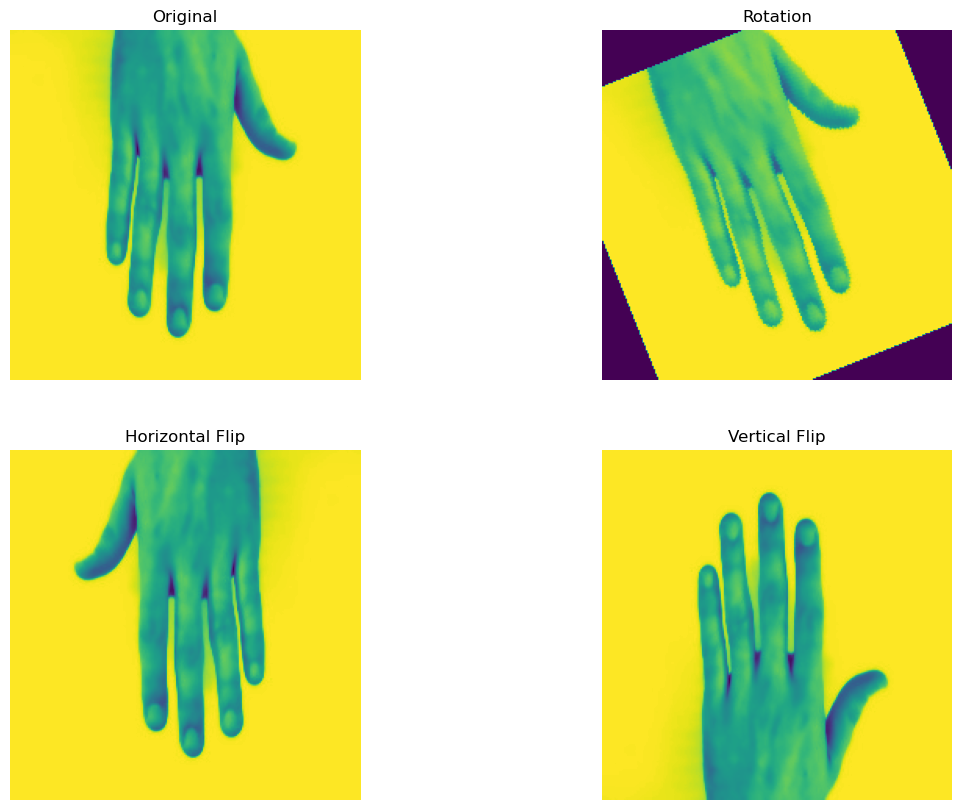

In [4]:
img_hand = Image.open('./Images_Afterpreprocess/Hand_0000002.jpg').convert('L')

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)

# Ảnh gốc.
plt.imshow(img_hand)
plt.title(f"Original", fontsize=12)
plt.axis("off")

# Xoay 45 độ.
plt.subplot(2, 2, 2)
img_rotation = transforms.RandomRotation(degrees= 45)(img_hand)
plt.imshow(img_rotation)
plt.title(f"Rotation", fontsize=12)
plt.axis("off")

# lật ảnh theo chiều ngang.
plt.subplot(2, 2, 3)
img_horizon = transforms.RandomHorizontalFlip()(img_hand)
plt.imshow(img_horizon)
plt.title(f"Horizontal Flip", fontsize=12)
plt.axis("off")

# Lật ảnh theo chiều dọc.
plt.subplot(2, 2, 4)
img_vertical = transforms.RandomVerticalFlip()(img_hand)
plt.imshow(img_vertical)
plt.title(f"Vertical Flip", fontsize=12)
plt.axis("off")

**Xây dựng một lớp custom dataset cho việc load dữ liệu**

In [10]:
df=pd.read_csv(csv_train_file_path)
classes=list(set(list(df['id'].values)))
classes=sorted(classes)

In [11]:
class MyDataset(Dataset):
    def __init__(self, file_path, df, classes,transforms=None, training=True):
        self.df = df
        self.classes=classes
        self.transforms = transforms
        self.training = training
        self.Path_to_image=file_path
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path = self.Path_to_image + '/' + self.df.loc[idx, 'imageName']
        img = Image.open(img_path).convert('RGB')
        if self.training:
            label = self.df.loc[idx,self.df.columns[0]]
            label = self.classes.index(label)
            label =torch.as_tensor(label, dtype=torch.int16)
            if self.transforms:
                img = self.transforms(img)
            return img, label
        else:
            if self.transforms:
                img = self.transforms(img)
            return img
        return img

**Xây dựng model và tiến hành training**

In [12]:
def get_model(num_classes = 189):
    model = models.resnet50(pretrained= True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features=in_features, out_features=num_classes)
    return model

def train_model(model, 
                training_data_loader, 
                valid_data_loader, 
                critertion,
                optimizer,
                num_epochs = 5,
                device = None):
    min_loss = np.inf
    valid_loss_history = []
    valid_acc_history = []
    training_loss_history = []
    training_acc_history = []
    
    for epoch in range(1, num_epochs + 1):
        print("Epoch %d/%d: " %(epoch, num_epochs))
        training_loss = 0
        valid_loss = 0
        running_loss = 0
        model.train()
        step = 1
        preds_accuracy = []
        labels_accuracy = []
        for images, labels in training_data_loader:
            if device is not None:
                images = images.to(device)
                labels = labels.type(torch.LongTensor)  
                labels = labels.to(device)
                
            #Dự đoán bằng model
            predictions = model(images)

            #Xóa bộ nhớ gradient của Pytorch
            optimizer.zero_grad()
            
            #Tính chi phí Loss 
            training_loss_step =  critertion(predictions, labels)
            training_loss_step.backward()

            #Cập nhật tham số bằng gradient descent trong Pytorch
            optimizer.step()
            training_loss  += training_loss_step.item()
            running_loss = training_loss/step
            step +=1

            labels_accuracy = np.concatenate((labels_accuracy, labels.cpu().numpy()), 0)
            preds_accuracy = np.concatenate((preds_accuracy, np.argmax(predictions.cpu().detach().numpy(), 1)), 0)
        
        training_loss_history.append(training_loss)
        training_accuracy = accuracy_score(labels_accuracy, preds_accuracy)
        training_acc_history.append(training_accuracy)
        print("Training loss: %.3f  Accuracy: %.3f" %(training_loss, training_accuracy))

        step =1 # reset step for validation
        preds_accuracy = []
        labels_accuracy = []
        model.eval() # Gọi hàm đánh giá của model

        #Trong bước đánh giá không cần thực hiện gradient descent để cập nhật tham số
        #Do đó không cần gọi đến grad() của Pytorch
        with torch.no_grad():
            for images, labels in valid_data_loader:
                if device is not None:
                    images = images.to(device)
                    labels = labels.type(torch.LongTensor)
                    labels = labels.to(device)
                
                
                predictions = model(images)
                valid_loss_step = critertion(predictions, labels)
                valid_loss += valid_loss_step.item()

                running_loss = valid_loss/step
                step+=1
                labels_accuracy = np.concatenate((labels_accuracy, labels.cpu().numpy()), 0)
                preds_accuracy = np.concatenate((preds_accuracy, np.argmax(predictions.cpu().detach().numpy(), 1)), 0)

        valid_loss_history.append(valid_loss)
        valid_accuracy = accuracy_score(labels_accuracy, preds_accuracy)
        valid_acc_history.append(valid_accuracy)
        print("Valid loss: %.3f     Accuracy: %.3f" % (valid_loss, valid_accuracy))
        if valid_loss <= min_loss:
            min_loss = valid_loss
            torch.save(model.state_dict(),'./apple_leaf_classifier_resnet50.pth')
            print("Model save with %.3f loss at Epoch %d" % (min_loss, epoch))
        print('\n===========================================================')
        print("Complete epoch %d/%d     Training loss: %.3f     Trainning accuracy: %.3f   Valid loss: %.3f    Valid accuracy: %.3f"\
                        %(epoch, num_epochs, training_loss,training_accuracy, valid_loss, valid_accuracy))
        print('============================================================')

    return training_loss_history,training_acc_history, valid_loss_history,valid_acc_history

Đọc dữ liệu từ file 'train.csv' để làm đầu vào cho lớp MyDataset

In [13]:
train_df = pd.read_csv(csv_train_file_path)

In [14]:
training_data, valid_data = train_test_split(train_df,test_size=0.3, random_state=82)

In [15]:
training_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

In [16]:
training_dataset = MyDataset(file_path, training_data, classes, transforms= training_transforms, training=True)
valid_dataset = MyDataset(file_path, valid_data, classes, transforms=valid_transforms, training=True)

In [17]:
training_data_loader = DataLoader(training_dataset, batch_size=16)
valid_data_loader = DataLoader(valid_dataset, batch_size=8)

In [18]:
#Tạo khung cho model
model = get_model(num_classes = 189)
model.eval()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
url3 = 'https://drive.google.com/uc?id=1V7ALrYOH4EiT2W8-IW2kTcPC_WsC7B20'
output3 = 'hand_resnet50.pth'
gdown.download(url3, output3, quiet=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1V7ALrYOH4EiT2W8-IW2kTcPC_WsC7B20
From (redirected): https://drive.google.com/uc?id=1V7ALrYOH4EiT2W8-IW2kTcPC_WsC7B20&confirm=t&uuid=7360c28f-d7a9-4989-930b-a169938022f9
To: /kaggle/working/hand_resnet50.pth
100%|██████████| 95.9M/95.9M [00:00<00:00, 272MB/s]


'hand_resnet50.pth'

In [20]:
#Tải mô hình đã được pre-trained sẵn bộ tham số tối ưu vào khung vừa tạo phía trên
if torch.cuda.is_available():
    model.load_state_dict(torch.load('./hand_resnet50.pth'))
else:
    model.load_state_dict(torch.load('./hand_resnet50.pth', map_location=torch.device('cpu')))

In [21]:
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
critertion = nn.CrossEntropyLoss()
num_epochs = 15

In [22]:
history = train_model(model, 
                    training_data_loader, 
                    valid_data_loader,
                    critertion,
                    optimizer,
                    num_epochs,
                    device)

Epoch 1/15: 
Training loss: 1933.339  Accuracy: 0.169
Valid loss: 1089.959     Accuracy: 0.358
Model save with 1089.959 loss at Epoch 1

Complete epoch 1/15     Training loss: 1933.339     Trainning accuracy: 0.169   Valid loss: 1089.959    Valid accuracy: 0.358
Epoch 2/15: 
Training loss: 939.216  Accuracy: 0.541
Valid loss: 548.981     Accuracy: 0.639
Model save with 548.981 loss at Epoch 2

Complete epoch 2/15     Training loss: 939.216     Trainning accuracy: 0.541   Valid loss: 548.981    Valid accuracy: 0.639
Epoch 3/15: 
Training loss: 487.810  Accuracy: 0.769
Valid loss: 244.404     Accuracy: 0.834
Model save with 244.404 loss at Epoch 3

Complete epoch 3/15     Training loss: 487.810     Trainning accuracy: 0.769   Valid loss: 244.404    Valid accuracy: 0.834
Epoch 4/15: 
Training loss: 273.221  Accuracy: 0.885
Valid loss: 160.570     Accuracy: 0.890
Model save with 160.570 loss at Epoch 4

Complete epoch 4/15     Training loss: 273.221     Trainning accuracy: 0.885   Valid lo

**Đánh giá**

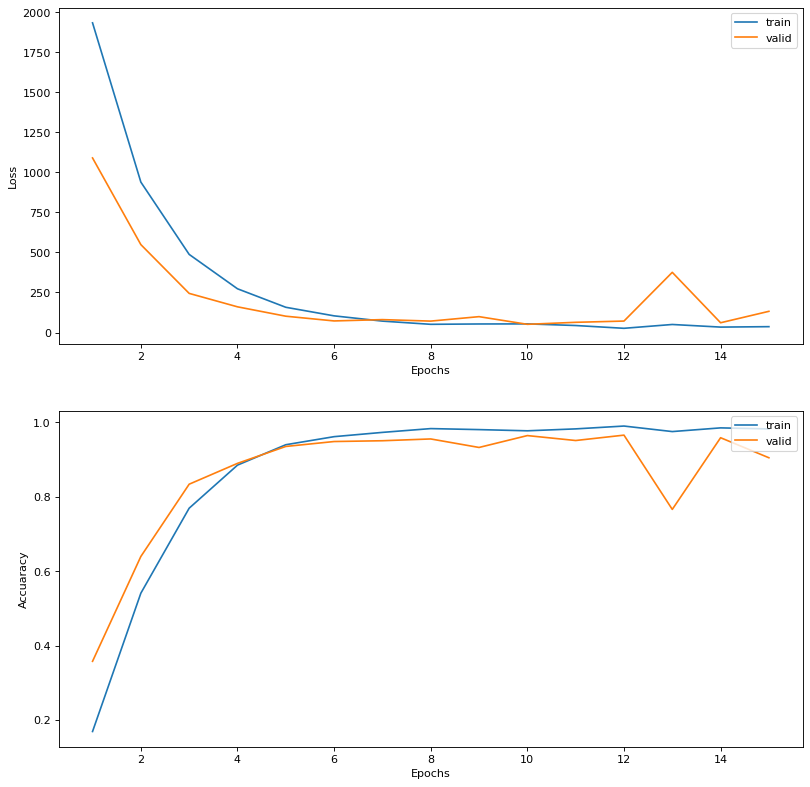

In [23]:
loss, acc, val_loss, val_acc = history
plt.figure(figsize=(12, 12), dpi=80)
plt.subplot(2,1,1)
plt.plot([i for i in range(1,len(loss)+1)],loss)
plt.plot([i for i in range(1,len(loss)+1)], val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'valid'], loc='upper right')

plt.subplot(2,1,2)
plt.plot([i for i in range(1,len(loss)+1)],acc)
plt.plot([i for i in range(1,len(loss)+1)], val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuaracy')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

**Ghi kết quả của tập validation ra file**

In [24]:
valid_dataset2 = MyDataset(file_path, valid_data, classes, transforms=valid_transforms, training=False)
valid_data_loader2 = DataLoader(valid_dataset2, batch_size= 8)

In [25]:
result =pd.DataFrame()
for imgs in valid_data_loader2:
    imgs = imgs.to(device)
    predictions = model(imgs)
    score = nn.Softmax(1)(predictions).detach().cpu().numpy()
    label= [classes[i] for i in np.argmax(score,axis=1)]
    output = pd.DataFrame(label, columns=['id'])
    result = pd.concat([result, output], ignore_index=True)

submission_df = result.copy()
submission_df['imageName'] = valid_data.imageName
submission_df = submission_df[['id','imageName']]

submission_df.to_csv('submission-hands-recognition-resnet50.csv', index=False)